# Accessibility Analysis

- This analysis will measure accessibility to schools and hospitals
- origins are derived from 100m grid blocks coming from WorldPop
- the accessibility measure is the distance to the nearest facility in meters

## Inputs:

#### origins: derived from a WorldPOP raster using the 'Raster pixels to Points' tool in QGIS 3, and saved as a shapefile
#### destinations: The combination of POIs from Overpass as points and centroids of polygons called through the GOSTNets OSMNX_POIs library.
#### The admin AOI will be used to create a bounding box to download the road network via OSMNX


### Import libraries

In [223]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point
import pickle
import matplotlib.pyplot as plt

In [225]:
# Get reference to GOSTNets

sys.path.append(r'/Users/tomgertin/repos/GOSTnets')
import GOSTnets as gn

In [226]:
from GOSTnets.fetch_pois import *

### Define folders and files

In [227]:
inputFolder = r'input_folder'
# define output folder
outputFolder = r'output_folder'
# define road graph
roadGraph = os.path.join(inputFolder, "OSM_Roads.pickle")

In [228]:
city_name = 'tamale'

In [229]:
# import extent
#extent = gpd.read_file("./admin/" + city_name + "_AOI.shp").set_crs(epsg=4326)
extent = gpd.read_file("../admin/" + city_name + ".shp").set_crs(epsg=4326)

In [230]:
# make sure crs is 4326
print(extent.crs)

EPSG:4326


In [231]:
#extent = box(*city_extent.total_bounds)

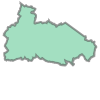

In [232]:
extent.geometry[0]

## We will extract OSM POIs

In [233]:
school_tags = {'amenity':['school', 'kindergarten', 'university', 'college']}
# Removing pharmacy from health_tags
health_tags = {'amenity':['clinic', 'hospital', 'health']}
police_tags = {'amenity':['police']}
fire_station_tags = {'amenity':['fire_station']}

In [234]:
tag_dictionary = {'schools': school_tags, 'health': health_tags, 'police': police_tags, 'fire': fire_station_tags}

In [235]:
try:
    os.mkdir(outputFolder + '/osm_infrastructure')
except FileExistsError:
    pass

In [236]:
queries = {}
for tags in tag_dictionary.items():
    print(tags[0])
    # create the OsmObject
    queries[tags[0]] = OsmObject(f'{tags[0]}', extent.geometry[0].buffer(0), tags[1])
query_results_gpd_dict = {}
for query in queries.items():
    print(query)
    result = query[1].GenerateOSMPOIs()
    
    # if query is not empty
    if result.empty == False:
        
        query[1].RemoveDupes(0.0005)
        
        #print(query[1].df)

        if 'name' in query[1].df.columns:
            query_results = query[1].df[['amenity','geometry','name']]
        else:
            query_results = query[1].df[['amenity','geometry']]

        # convert to GeoDataFrame
        query_results_gpd = gpd.GeoDataFrame(query_results, crs = "epsg:4326", geometry = 'geometry')
        query_results_gpd.to_file(outputFolder + f'/osm_infrastructure/osm_{query[0]}.shp')

        #save result in query_results_gpd_dict 
        query_results_gpd_dict[query[0]] = query_results_gpd

schools
health
police
fire
('schools', <GOSTnets.fetch_pois.OsmObject object at 0x197f3f010>)
is df empty: False


/Users/tomgertin/repos/GOSTnets/GOSTnets/fetch_pois.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid
/Users/tomgertin/repos/GOSTnets/GOSTnets/fetch_pois.py:99: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf['geometry'].buffer(buf_width)


('health', <GOSTnets.fetch_pois.OsmObject object at 0x1916fb2d0>)
is df empty: False


/Users/tomgertin/repos/GOSTnets/GOSTnets/fetch_pois.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid
/Users/tomgertin/repos/GOSTnets/GOSTnets/fetch_pois.py:99: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf['geometry'].buffer(buf_width)
/Users/tomgertin/repos/GOSTnets/GOSTnets/fetch_pois.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid


('police', <GOSTnets.fetch_pois.OsmObject object at 0x197f6f390>)
is df empty: False
('fire', <GOSTnets.fetch_pois.OsmObject object at 0x197f6f8d0>)
is df empty: False


/Users/tomgertin/repos/GOSTnets/GOSTnets/fetch_pois.py:99: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf['geometry'].buffer(buf_width)
/Users/tomgertin/repos/GOSTnets/GOSTnets/fetch_pois.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid
/Users/tomgertin/repos/GOSTnets/GOSTnets/fetch_pois.py:99: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf['geometry'].buffer(buf_width)


## We will extract the Roads and convert into a graph

In [237]:
# This is the section where we can adjust the road speeds
if not os.path.exists(roadGraph):
    extent = box(*extent.total_bounds)
    G = ox.graph_from_polygon(extent, network_type = 'drive_service')
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length')
    # save the largest subgraph
   
    # compatible with NetworkX 2.4
    list_of_subgraphs = list(G.subgraph(c).copy() for c in nx.strongly_connected_components(G))
    max_graph = None
    max_edges = 0
    for i in list_of_subgraphs:
        if i.number_of_edges() > max_edges:
            max_edges = i.number_of_edges()
            max_graph = i

    # set your graph equal to the largest sub-graph
    G = max_graph

    # networkx ver 2
    #nx.write_gpickle(G, roadGraph)
    
    # for networkX ver 3
    with open(roadGraph, 'wb') as f:
        pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)
else:
    # networkx ver 2
    #G = nx.read_gpickle(roadGraph)
    
    # for networkX ver 3
    with open(roadGraph, 'rb') as f:
        G = pickle.load(f)
    
    G = gn.convert_network_to_time(G, 'length')

### Inspect the road graph as a shapefile

In [238]:
roads = gn.edge_gdf_from_graph(G)

In [239]:
pd.set_option('display.max_columns', None)

### Sometimes the highway value can have a list instead of a single value, in these cases the code below will replace the list with the first value of the list

In [240]:
def replace_hwy(x):
    if isinstance(x, list):
        x = x[0]
    return x

In [241]:
roads['highway'] = roads.apply(lambda x: replace_hwy(x['highway']), axis=1)

In [242]:
roads[:2]

,stnode,endnode,reversed,length,time,name,highway,junction,tunnel,access,maxspeed,ref,lanes,mode,service,osmid,bridge,oneway,geometry
0,30932706,4829322405,False,37.954,6.83172,Gumani Street,unclassified,NaN,NaN,NaN,NaN,NaN,NaN,drive,NaN,4816061,NaN,False,"LINESTRING (-0.83902 9.43728, -0.83868 9.43726)"
1,30932706,1785712350,False,102.716,18.48888,Gumani Road,unclassified,NaN,NaN,NaN,NaN,NaN,NaN,drive,NaN,4816052,NaN,False,"LINESTRING (-0.83902 9.43728, -0.83902 9.43679..."


In [243]:
if not os.path.exists(outputFolder + '/OSM_Roads/OSM_Roads.shp'):
    #roads['oneway'] = roads.oneway.astype(int)
    roads = roads[['length','time','mode','geometry']]
    roads.to_file(outputFolder + '/OSM_Roads')

### Snap destinations to the road graph

In [244]:
snapped_destinations_dict = {}
for results_gpd in query_results_gpd_dict.items():
    snapped_destinations = gn.pandana_snap(G, query_results_gpd_dict[results_gpd[0]])
    snapped_destinations_dict[results_gpd[0]] = list(snapped_destinations['NN'].unique())

In [245]:
# snapped_destinations_dict

## Isochrones processing

In [246]:
threshold_list = {
    'schools': [800,1600,2400],
    'health': [1000,2000,3000]
}

In [247]:
# find graph utm zone
G_utm = gn.utm_of_graph(G)

In [248]:
def isochrone_processing(amenity_type):
    amenity_threshold_list = threshold_list.get(amenity_type)
    if amenity_threshold_list == None:
        return "Amenity type not found"
    # if no destinations for amenity type exist
    if snapped_destinations_dict.get(amenity_type) == None:
        print(f"no destinations for {amenity_type} exist")
    else:
        for threshold in amenity_threshold_list:
            print(threshold)
            iso_gdf = gn.make_iso_polys(G, snapped_destinations_dict[amenity_type], [threshold], edge_buff=300, node_buff=300, weight = 'length', measure_crs = G_utm)
            dissolved = iso_gdf.dissolve(by="thresh")
            gdf_out = dissolved.explode()
            gdf_out2 = gdf_out.reset_index()
            # save file
            gdf_out2.to_file(outputFolder + f'/{city_name}_AOI_accessibility_{amenity_type}_isochrones_{threshold}m.shp')
        

In [249]:
for key in threshold_list:
    print(key)
    isochrone_processing(key)

schools
800
merge all edges and nodes
unary_union


/var/folders/gr/04wfn6914nn08mfvwlf0_j2h0000gn/T/ipykernel_12678/3651699368.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_out = dissolved.explode()


1600
merge all edges and nodes
unary_union


/var/folders/gr/04wfn6914nn08mfvwlf0_j2h0000gn/T/ipykernel_12678/3651699368.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_out = dissolved.explode()


2400
merge all edges and nodes
unary_union


/var/folders/gr/04wfn6914nn08mfvwlf0_j2h0000gn/T/ipykernel_12678/3651699368.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_out = dissolved.explode()


health
1000
merge all edges and nodes
unary_union


/var/folders/gr/04wfn6914nn08mfvwlf0_j2h0000gn/T/ipykernel_12678/3651699368.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_out = dissolved.explode()


2000
merge all edges and nodes
unary_union


/var/folders/gr/04wfn6914nn08mfvwlf0_j2h0000gn/T/ipykernel_12678/3651699368.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_out = dissolved.explode()


3000
merge all edges and nodes
unary_union


/var/folders/gr/04wfn6914nn08mfvwlf0_j2h0000gn/T/ipykernel_12678/3651699368.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_out = dissolved.explode()
